###Практика по ООП
В командах из четырех человек написать чат (клиент+сервер) работающий по UDP. Код писать в объектно-ориентированной парадигме, максимально разделяя и обосабливая классы.
Схема реализации ниже. Сервер должен слать индивидуальное сообщение клиенту в момент подключения. Остальные сообщения должны идти широковещательно (broadcast).
Пример реализации широковещательного сообщения ниже в блоке кода.
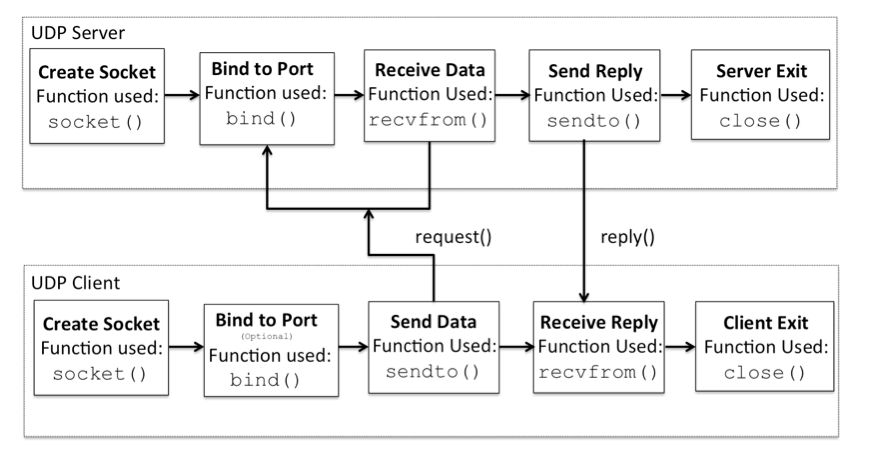

### Функционал приложения

1. Сервер принимает неограниченное число сообщений от клиентов и рассылает их широковещательно (альтернативный вариант: сохраняет список подключенных клиентов и рассылает им целевые сообщения);
2. Клиент имеет только одно активное подключение с сервером;
3. Клиент отображает текущие сообщения чата со временем и никнеймами пользователей (без промотки истории) может отправлять текстовые сообщения (+дополнительно можно отправлять текст с ***форматированием*** или даже с формулами LaTEX, которые сервер может распаковывать и отрисовывать);
4. Сервер имеет фильтр сообщений по ключевым словам, заменяя или отдельные слова, или все сообщение на приемлемые тематике чата;
5. Клиент имеет возможность сменить никнейм, настроить подключение (IP, порт) или разорвать его (консольные команды, или графический интерфейс);
6. Сервер имеет возможность сменить порт, принудительно отключить конкретного клиента, просмотреть фильтр слов, добавить или удалить оттуда фильтр для конкретной сессии (+дополнительно можно сохранять изменения в файл и загружать их оттуда при старте сервера; +если список клиентов сохраняется, возможность добавить клиента в ЧС по IP);
7. Сервер ведет лог чата (сохраняет сообщения+время+никнейм в файл).

In [ ]:
import socket
import time

server = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)

# Enable port reusage so we will be able to run multiple clients and servers on single (host, port). 
# Do not use socket.SO_REUSEADDR except you using linux(kernel<3.9): 
# goto https://stackoverflow.com/questions/14388706/how-do-so-reuseaddr-and-so-reuseport-differ for more information.
# For linux hosts all sockets that want to share the same address and port combination must belong to processes that share the same effective user ID!
# So, on linux(kernel>=3.9) you have to run multiple servers and clients under one user to share the same (host, port).
# Thanks to @stevenreddie
server.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEPORT, 1)

# Enable broadcasting mode
server.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)

# Set a timeout so the socket does not block
# indefinitely when trying to receive data.
server.settimeout(0.2)
message = b"your very important message"
while True:
    server.sendto(message, ('<broadcast>', 37020))
    print("message sent!")
    time.sleep(1)

Пример кода клиента

In [ ]:
import socket

client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP) # UDP

client.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEPORT, 1)

# Enable broadcasting mode
client.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)

client.bind(("", 37020))
while True:
    # Thanks @seym45 for a fix
    data, addr = client.recvfrom(1024)
    print("received message: %s"%data)

И для референса, написанный клиент+сервер в одном коде, но в структурной парадигме: https://github.com/Ayanjit/python-UDP-Chat/blob/master/Chat.py


Можно внимательно изучить и переписать в объектно-ориентированной.

In [1]:
import socket
import threading
import queue
import sys
import random
import os


#Client Code
def ReceiveData(sock):
    while True:
        try:
            data,addr = sock.recvfrom(1024)
            print(data.decode('utf-8'))
        except:
            pass

def RunClient(serverIP):
    host = socket.gethostbyname(socket.gethostname())
    port = random.randint(6000,10000)
    print('Client IP->'+str(host)+' Port->'+str(port))
    server = (str(serverIP),5000)
    s = socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    s.bind((host,port))

    name = input('Please write your name here: ')
    if name == '':
        name = 'Guest'+str(random.randint(1000,9999))
        print('Your name is:'+name)
    s.sendto(name.encode('utf-8'),server)
    threading.Thread(target=ReceiveData,args=(s,)).start()
    while True:
        data = input()
        if data == 'qqq':
            break
        elif data=='':
            continue
        data = '['+name+']' + '->'+ data
        s.sendto(data.encode('utf-8'),server)
    s.sendto(data.encode('utf-8'),server)
    s.close()
    os._exit(1)
#Client Code Ends Here


#Server Code
def RecvData(sock,recvPackets):
    while True:
        data,addr = sock.recvfrom(1024)
        recvPackets.put((data,addr))

def RunServer():
    host = socket.gethostbyname(socket.gethostname())
    port = 5000
    print('Server hosting on IP-> '+str(host))
    s = socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    s.bind((host,port))
    clients = set()
    recvPackets = queue.Queue()

    print('Server Running...')

    threading.Thread(target=RecvData,args=(s,recvPackets)).start()

    while True:
        while not recvPackets.empty():
            data,addr = recvPackets.get()
            if addr not in clients:
                clients.add(addr)
                continue
            clients.add(addr)
            data = data.decode('utf-8')
            if data.endswith('qqq'):
                clients.remove(addr)
                continue
            print(str(addr)+data)
            for c in clients:
                if c!=addr:
                    s.sendto(data.encode('utf-8'),c)
    s.close()
#Serevr Code Ends Here

if __name__ == '__main__':
    if len(sys.argv)==1:
        RunServer()
    elif len(sys.argv)==2:
        RunClient(sys.argv[1])
    else:
        print('Run Serevr:-> python Chat.py')
        print('Run Client:-> python Chat.py <ServerIP>')

Run Serevr:-> python Chat.py
Run Client:-> python Chat.py <ServerIP>
